In [2]:
# Imports y carga
import pandas as pd
import geopandas as gpd
from pathlib import Path
import folium
from folium.plugins import MarkerCluster


In [16]:
# Detecta y cambia al repo root (donde está pyproject.toml), si existe
from pathlib import Path
import os, sys

cwd = Path.cwd()
repo_root = None
for p in [cwd] + list(cwd.parents):
    if (p / "pyproject.toml").exists():
        repo_root = p
        break

if repo_root:
    os.chdir(repo_root)
    print("Changed working dir to repo root:", repo_root)
else:
    print("Repo root with pyproject.toml not found. Current cwd remains:", cwd)
    print("You can also set repo root manually, e.g.: os.chdir('/home/tepeve/personal/repos/ba_ooh_ads')")
print("Now cwd:", Path.cwd())
print("Python executable:", sys.executable)
print(".venv exists here?:", (Path('.venv').exists()))

Changed working dir to repo root: /home/tepeve/personal/repos/ba_ooh_ads
Now cwd: /home/tepeve/personal/repos/ba_ooh_ads
Python executable: /home/tepeve/personal/repos/ba_ooh_ads/.venv/bin/python
.venv exists here?: True


In [17]:
# Cell 1: diagnóstico rápido del entorno y paths
from pathlib import Path
import sys, os
print("Python executable:", sys.executable)
print("Working dir:", Path.cwd())
print(".venv exists?:", Path(".venv").exists())
p = Path("data/processed/anuncios_geolocalizados.parquet")
print("Expected parquet path:", p.resolve())
print("data/processed exists?:", (p.parent).exists())
print("Listing data/processed:", list((p.parent).iterdir()) if (p.parent).exists() else "missing")
print("Parquet exists?:", p.exists())

Python executable: /home/tepeve/personal/repos/ba_ooh_ads/.venv/bin/python
Working dir: /home/tepeve/personal/repos/ba_ooh_ads
.venv exists?: True
Expected parquet path: /home/tepeve/personal/repos/ba_ooh_ads/data/processed/anuncios_geolocalizados.parquet
data/processed exists?: True
Listing data/processed: [PosixPath('data/processed/anuncios_geolocalizados.parquet'), PosixPath('data/processed/anuncios_excluidos.csv'), PosixPath('data/processed/.gitkeep')]
Parquet exists?: True


In [18]:

p = Path("data/processed/anuncios_geolocalizados.parquet")
df = pd.read_parquet(p)
print("Loaded:", len(df), "rows")
print("Columns:", df.columns.tolist())

Loaded: 18340 rows
Columns: ['long', 'lat', 'nro_anuncio', 'estado_anuncio', 'fecha_alta_anuncio', 'clase', 'tipo', 'caracteristica', 'metros', 'zona', 'calle_nombre', 'calle_altura', 'direccion', 'ciudad', 'pais', 'calle_nombre_norm', 'full_address', 'needs_geocoding', 'h3_res9', 'id_left', 'objeto_left', 'nombre', 'comuna_left', 'perimetro_', 'area_metro', 'id_right', 'objeto_right', 'comuna_right', 'barrios', 'perimetro', 'area_left', 'distrito', 'area_right', 'distrito_simply', 'distrito_desc']


In [19]:
# GeoDataFrame de puntos
df_points = df.copy()
# Asegurarse que lat/long estén presentes y convertidos a numérico
df_points['lat'] = pd.to_numeric(df_points['lat'], errors='coerce')
df_points['long'] = pd.to_numeric(df_points['long'], errors='coerce')
gdf_points = gpd.GeoDataFrame(
    df_points[df_points['lat'].notna() & df_points['long'].notna()].copy(),
    geometry=gpd.points_from_xy(df_points.loc[df_points['lat'].notna() & df_points['long'].notna(), 'long'],
                                df_points.loc[df_points['lat'].notna() & df_points['long'].notna(), 'lat']),
    crs="EPSG:4326"
)
print("Points:", len(gdf_points))

Points: 18332


In [20]:
gdf_points.head()

,long,lat,nro_anuncio,estado_anuncio,fecha_alta_anuncio,clase,tipo,caracteristica,metros,zona,...,objeto_right,comuna_right,barrios,perimetro,area_left,distrito,area_right,distrito_simply,distrito_desc,geometry
0,-58.444474,-34.608641,940631631,ACTIVO,1994-09-29,COMBINADO,MARQUESINA/EPP,LUMINOSO,1,2,...,COMUNA,6.0,Caballito,10990.96,6851029.56,None,None,None,None,POINT (-58.44447 -34.60864)
1,-58.389475,-34.601973,940631641,ACTIVO,1994-09-29,COMBINADO,MARQUESINA/EPP,LUMINOSO,1,2,...,COMUNA,1.0,"Constitucion, San Telmo, Monserrat, Retiro, Pu...",36351.19,17801036.28,None,None,None,None,POINT (-58.38948 -34.60197)
2,-58.450459,-34.599506,940638421,ACTIVO,1994-01-03,COMBINADO,FRONTAL,LUMINOSO,24,2,...,COMUNA,15.0,"Villa Ortuzar, Agronomia, Paternal, Parque Cha...",17832.59,14322898.13,None,None,None,None,POINT (-58.45046 -34.59951)
3,-58.450459,-34.599506,940638431,ACTIVO,1994-01-03,COMBINADO,SALIENTE,LUMINOSO,2,2,...,COMUNA,15.0,"Villa Ortuzar, Agronomia, Paternal, Parque Cha...",17832.59,14322898.13,None,None,None,None,POINT (-58.45046 -34.59951)
4,-58.429607,-34.615170,940638441,ACTIVO,1994-01-03,COMBINADO,SALIENTE,LUMINOSO,2,2,...,COMUNA,5.0,"Almagro, Boedo",12323.43,6660603.77,None,None,None,None,POINT (-58.42961 -34.61517)


In [21]:
# Cargar capas administrativas (si existen)
external = Path("data/external")
layers = {}
for name in ["barrios","comunas","zonificacion"]:
    f = external / f"{name}.parquet"
    if f.exists():
        g = gpd.read_parquet(f)
        print(name, "loaded:", len(g), "crs:", g.crs)
        if g.crs != gdf_points.crs:
            g = g.to_crs(gdf_points.crs)
            print(name, "reprojected to", g.crs)
        layers[name] = g
    else:
        print(name, "not found at", f)

barrios loaded: 48 crs: {"$schema": "https://proj.org/schemas/v0.7/projjson.schema.json", "type": "GeographicCRS", "name": "WGS 84", "datum_ensemble": {"name": "World Geodetic System 1984 ensemble", "members": [{"name": "World Geodetic System 1984 (Transit)"}, {"name": "World Geodetic System 1984 (G730)"}, {"name": "World Geodetic System 1984 (G873)"}, {"name": "World Geodetic System 1984 (G1150)"}, {"name": "World Geodetic System 1984 (G1674)"}, {"name": "World Geodetic System 1984 (G1762)"}, {"name": "World Geodetic System 1984 (G2139)"}, {"name": "World Geodetic System 1984 (G2296)"}], "ellipsoid": {"name": "WGS 84", "semi_major_axis": 6378137, "inverse_flattening": 298.257223563}, "accuracy": "2.0", "id": {"authority": "EPSG", "code": 6326}}, "coordinate_system": {"subtype": "ellipsoidal", "axis": [{"name": "Geodetic latitude", "abbreviation": "Lat", "direction": "north", "unit": "degree"}, {"name": "Geodetic longitude", "abbreviation": "Lon", "direction": "east", "unit": "degree"}

In [22]:
layers['zonificacion'].head()

,distrito,area,geometry,distrito_simply,distrito_desc
0,E4 3,861946.770220,"POLYGON ((-58.45002 -34.53489, -58.45001 -34.5...",E4,EQUIPAMIENTO ESPECIAL
1,UP,93633.911434,"POLYGON ((-58.43953 -34.54007, -58.43915 -34.5...",UP,URBANIZACIÓN PARQUE
2,R2a I,167191.848540,"POLYGON ((-58.37606 -34.59239, -58.3761 -34.59...",R2a,RESIDENCIAL GENERAL DE DENSIDAD ALTA
3,UP,18519.259397,"POLYGON ((-58.45027 -34.55823, -58.45013 -34.5...",UP,URBANIZACIÓN PARQUE
4,UP,40471.046561,"POLYGON ((-58.45081 -34.53348, -58.45346 -34.5...",UP,URBANIZACIÓN PARQUE


In [23]:
# Recuento de asignaciones ya guardadas
for col in ["barrio","comuna","distrito_simply","distrito"]:
    if col in df.columns:
        print(col, "non-null:", df[col].notna().sum())

distrito_simply non-null: 0
distrito non-null: 0


In [24]:
# Re-join check (usa subset para rapidez)
subset = gdf_points.sample(min(5000, len(gdf_points)), random_state=1)  # reduce si es muy grande
print("Subset size:", len(subset))

results = {}
for name, gdf_admin in layers.items():
    # asegurarse del CRS
    if gdf_admin.crs != subset.crs:
        gdf_admin = gdf_admin.to_crs(subset.crs)
    joined = gpd.sjoin(subset, gdf_admin, how="left", predicate="within")
    # columnas nuevas desde admin (excluimos geometry/index_right)
    results[name] = joined
    print(f"{name}: joined rows non-null index_right:", joined['index_right'].notna().sum())

Subset size: 5000
barrios: joined rows non-null index_right: 4943
comunas: joined rows non-null index_right: 4943
zonificacion: joined rows non-null index_right: 4943


In [25]:
# Ejecutar para inspeccionar CRS y coordenadas de muestra
for name in list(layers.keys()):
    g = layers[name]
    print(name, "crs:", g.crs)
    # Mostrar bounds y primer geometry en coordenadas crs actual
    geom = g.geometry.iloc[0]
    print(" bounds:", geom.bounds)
    print(" sample coords (first 1-2 points):")
    coords = None
    try:
        # intenta acceder a unos pocos puntos del polígono para ver si son lat/lon o metros
        if geom.geom_type == "Polygon":
            coords = list(geom.exterior.coords)[:4]
        elif geom.geom_type == "MultiPolygon":
            coords = list(geom.geoms[0].exterior.coords)[:4]
        print(coords)
    except Exception as e:
        print("  (no se pudo extraer coords):", e)
    print("---")

barrios crs: {"$schema": "https://proj.org/schemas/v0.7/projjson.schema.json", "type": "GeographicCRS", "name": "WGS 84", "datum_ensemble": {"name": "World Geodetic System 1984 ensemble", "members": [{"name": "World Geodetic System 1984 (Transit)"}, {"name": "World Geodetic System 1984 (G730)"}, {"name": "World Geodetic System 1984 (G873)"}, {"name": "World Geodetic System 1984 (G1150)"}, {"name": "World Geodetic System 1984 (G1674)"}, {"name": "World Geodetic System 1984 (G1762)"}, {"name": "World Geodetic System 1984 (G2139)"}, {"name": "World Geodetic System 1984 (G2296)"}], "ellipsoid": {"name": "WGS 84", "semi_major_axis": 6378137, "inverse_flattening": 298.257223563}, "accuracy": "2.0", "id": {"authority": "EPSG", "code": 6326}}, "coordinate_system": {"subtype": "ellipsoidal", "axis": [{"name": "Geodetic latitude", "abbreviation": "Lat", "direction": "north", "unit": "degree"}, {"name": "Geodetic longitude", "abbreviation": "Lon", "direction": "east", "unit": "degree"}]}, "scope"

In [26]:
# Reprojectar todas las capas a EPSG:4326 y verificar
for name in list(layers.keys()):
    g = layers[name]
    # si crs es None, intenta asumir (NO asumir salvo que conozcas el CRS) — idealmente conocer origen
    if g.crs is None:
        raise RuntimeError(f"Layer {name} tiene crs=None. Necesitamos conocer su CRS original antes de reproyectar.")
    if g.crs.to_string() != "EPSG:4326":
        layers[name] = g.to_crs("EPSG:4326")
        print(f"{name} reproyectado a EPSG:4326")
    else:
        print(f"{name} ya estaba en EPSG:4326")
# ver ejemplo de coords ahora
print("Primeros coords de zonificacion (lat/lon):", list(layers['zonificacion'].geometry.iloc[0].exterior.coords)[:4])

barrios ya estaba en EPSG:4326
comunas ya estaba en EPSG:4326
zonificacion ya estaba en EPSG:4326
Primeros coords de zonificacion (lat/lon): [(-58.45001865045971, -34.53489314875968), (-58.45000998291637, -34.53503267610353), (-58.450014287298366, -34.53515670165396), (-58.45008920604499, -34.535267616474414)]


In [32]:
layers["comunas"]

,id,objeto,comuna,barrios,perimetro,area,geometry
0,1,COMUNA,1,"Constitucion, San Telmo, Monserrat, Retiro, Pu...",36351.19,17801036.28,"MULTIPOLYGON (((-58.34892 -34.61698, -58.34901..."
1,2,COMUNA,2,Recoleta,25965.02,6433391.77,"POLYGON ((-58.38039 -34.56847, -58.38037 -34.5..."
2,3,COMUNA,3,"San Cristobal, Balvanera",10486.26,6385992.08,"POLYGON ((-58.41192 -34.59801, -58.4103 -34.59..."
3,4,COMUNA,4,"Barracas, La Boca, Parque Patricios, Nueva Pom...",35481.84,21690646.89,"POLYGON ((-58.35521 -34.61944, -58.35515 -34.6..."
4,5,COMUNA,5,"Almagro, Boedo",12323.43,6660603.77,"POLYGON ((-58.41287 -34.61412, -58.41282 -34.6..."
5,6,COMUNA,6,Caballito,10990.96,6851029.56,"POLYGON ((-58.43061 -34.60705, -58.43056 -34.6..."
6,7,COMUNA,7,"Flores, Parque Chacabuco",17972.26,12422902.00,"POLYGON ((-58.452 -34.62975, -58.45158 -34.630..."
7,8,COMUNA,8,"Villa Lugano, Villa Riachuelo, Villa Soldati",20952.25,22233096.59,"POLYGON ((-58.44913 -34.65117, -58.44883 -34.6..."
8,9,COMUNA,9,"Parque Avellaneda, Mataderos, Liniers",21411.74,16505307.34,"POLYGON ((-58.51925 -34.63301, -58.51908 -34.6..."
9,10,COMUNA,10,"Floresta, Monte Castro, Velez Sarsfield, Versa...",18332.04,12656558.14,"POLYGON ((-58.48834 -34.62017, -58.4882 -34.62..."


In [ ]:
layers["barrios"]

,id,objeto,nombre,comuna,perimetro_,area_metro,geometry
0,1,BARRIO,Agronomia,15,6556.17,2122169.54,"POLYGON ((-58.47589 -34.59173, -58.47598 -34.5..."
1,2,BARRIO,Almagro,5,8537.90,4050752.63,"POLYGON ((-58.416 -34.59786, -58.4157 -34.5978..."
2,3,BARRIO,Balvanera,3,8375.82,4342280.68,"POLYGON ((-58.39294 -34.59964, -58.39277 -34.6..."
3,4,BARRIO,Barracas,4,12846.58,7955144.83,"POLYGON ((-58.37066 -34.6295, -58.37064 -34.62..."
4,5,BARRIO,Belgrano,13,20430.59,8060009.10,"POLYGON ((-58.45167 -34.53565, -58.45168 -34.5..."
5,6,BARRIO,La Boca,4,20029.29,5037482.05,"POLYGON ((-58.35147 -34.61936, -58.35144 -34.6..."
6,7,BARRIO,Boedo,5,6602.51,2609851.12,"POLYGON ((-58.41178 -34.63036, -58.41178 -34.6..."
7,8,BARRIO,Caballito,6,10990.96,6851029.56,"POLYGON ((-58.4278 -34.62208, -58.42749 -34.62..."
8,9,BARRIO,Chacarita,15,7724.85,3115707.40,"POLYGON ((-58.46023 -34.5783, -58.4602 -34.578..."
9,10,BARRIO,Coghlan,12,4627.56,1279951.49,"POLYGON ((-58.46919 -34.55893, -58.46893 -34.5..."


In [27]:
layers["zonificacion"]

,distrito,area,geometry,distrito_simply,distrito_desc
0,E4 3,861946.770220,"POLYGON ((-58.45002 -34.53489, -58.45001 -34.5...",E4,EQUIPAMIENTO ESPECIAL
1,UP,93633.911434,"POLYGON ((-58.43953 -34.54007, -58.43915 -34.5...",UP,URBANIZACIÓN PARQUE
2,R2a I,167191.848540,"POLYGON ((-58.37606 -34.59239, -58.3761 -34.59...",R2a,RESIDENCIAL GENERAL DE DENSIDAD ALTA
3,UP,18519.259397,"POLYGON ((-58.45027 -34.55823, -58.45013 -34.5...",UP,URBANIZACIÓN PARQUE
4,UP,40471.046561,"POLYGON ((-58.45081 -34.53348, -58.45346 -34.5...",UP,URBANIZACIÓN PARQUE
...,...,...,...,...,...
970,UP,291606.478268,"POLYGON ((-58.40418 -34.56373, -58.40392 -34.5...",UP,URBANIZACIÓN PARQUE
971,UP,426331.238140,"POLYGON ((-58.42949 -34.55072, -58.42935 -34.5...",UP,URBANIZACIÓN PARQUE
972,UF,31166.553905,"POLYGON ((-58.36358 -34.64788, -58.36364 -34.6...",UF,URBANIZACIÓN FUTURA
973,UF,31166.553905,"POLYGON ((-58.36202 -34.64759, -58.36204 -34.6...",UF,URBANIZACIÓN FUTURA


In [28]:
zm = folium.Map(location=[-34.61, -58.38], zoom_start=12, tiles="cartodbpositron")
if "zonificacion" in layers:
    folium.GeoJson(layers["zonificacion"].to_json(), name="zonificacion",
                   style_function=lambda feat: {"color":"#444444","weight":1,"fillOpacity":0.1}).add_to(zm)

    
zm.save("data/outputs/check_zones_map.html")


In [29]:
# Mapa folium con polígonos de barrios (si están) y cluster de puntos
center = [-34.61, -58.38]  # CABA approx
m = folium.Map(location=center, zoom_start=12, tiles="cartodbpositron")

# capas de polígonos (ej. barrios)
if "barrios" in layers:
    folium.GeoJson(layers["barrios"].to_json(),
                   name="barrios",
                   style_function=lambda feat: {"color":"#444444","weight":1,"fillOpacity":0.1}
                  ).add_to(m)

# puntos (cluster)
mc = MarkerCluster()
for idx, row in gdf_points.head(2000).iterrows():  # limitar para performance
    mc.add_child(folium.CircleMarker(location=(row['lat'], row['long']),
                                     radius=3,
                                     color="red",
                                     fill=True, fill_opacity=0.7,
                                     popup=str(row.get('full_address',''))))
m.add_child(mc)
m.save("data/outputs/check_spatial_map.html")
print("Map saved to outputs/check_spatial_map.html (open en tu navegador)")

Map saved to outputs/check_spatial_map.html (open en tu navegador)


In [30]:

gdf_points

,long,lat,nro_anuncio,estado_anuncio,fecha_alta_anuncio,clase,tipo,caracteristica,metros,zona,...,objeto_right,comuna_right,barrios,perimetro,area_left,distrito,area_right,distrito_simply,distrito_desc,geometry
0,-58.444474,-34.608641,940631631,ACTIVO,1994-09-29,COMBINADO,MARQUESINA/EPP,LUMINOSO,1,2,...,COMUNA,6.0,Caballito,10990.96,6851029.56,None,None,None,None,POINT (-58.44447 -34.60864)
1,-58.389475,-34.601973,940631641,ACTIVO,1994-09-29,COMBINADO,MARQUESINA/EPP,LUMINOSO,1,2,...,COMUNA,1.0,"Constitucion, San Telmo, Monserrat, Retiro, Pu...",36351.19,17801036.28,None,None,None,None,POINT (-58.38948 -34.60197)
2,-58.450459,-34.599506,940638421,ACTIVO,1994-01-03,COMBINADO,FRONTAL,LUMINOSO,24,2,...,COMUNA,15.0,"Villa Ortuzar, Agronomia, Paternal, Parque Cha...",17832.59,14322898.13,None,None,None,None,POINT (-58.45046 -34.59951)
3,-58.450459,-34.599506,940638431,ACTIVO,1994-01-03,COMBINADO,SALIENTE,LUMINOSO,2,2,...,COMUNA,15.0,"Villa Ortuzar, Agronomia, Paternal, Parque Cha...",17832.59,14322898.13,None,None,None,None,POINT (-58.45046 -34.59951)
4,-58.429607,-34.615170,940638441,ACTIVO,1994-01-03,COMBINADO,SALIENTE,LUMINOSO,2,2,...,COMUNA,5.0,"Almagro, Boedo",12323.43,6660603.77,None,None,None,None,POINT (-58.42961 -34.61517)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18335,-58.385026,-34.590605,940550961,ACTIVO,1994-05-02,AVISO,SALIENTE,SIMPLE,1,2,...,COMUNA,1.0,"Constitucion, San Telmo, Monserrat, Retiro, Pu...",36351.19,17801036.28,None,None,None,None,POINT (-58.38503 -34.59061)
18336,-58.373533,-34.593725,940605441,ACTIVO,1994-05-23,AVISO,FRONTAL,SIMPLE,32,1,...,COMUNA,1.0,"Constitucion, San Telmo, Monserrat, Retiro, Pu...",36351.19,17801036.28,None,None,None,None,POINT (-58.37353 -34.59372)
18337,-58.373146,-34.602053,940553071,ACTIVO,1994-05-03,AVISO,FRONTAL,SIMPLE,150,2,...,COMUNA,1.0,"Constitucion, San Telmo, Monserrat, Retiro, Pu...",36351.19,17801036.28,None,None,None,None,POINT (-58.37315 -34.60205)
18338,-58.410795,-34.580658,940551401,ACTIVO,1994-04-29,AVISO,FRONTAL,SIMPLE,1,1,...,COMUNA,14.0,Palermo,22834.18,15922563.51,None,None,None,None,POINT (-58.4108 -34.58066)


In [ ]:
### este bloque anda bien para cargar zonificaciones desde govmaps

import requests
import subprocess
from io import BytesIO

URL_ZONIFICACIONES = "https://cdn.buenosaires.gob.ar/datosabiertos/datasets/secretaria-de-desarrollo-urbano/codigo-planeamiento-urbano/codigo-de-planeamiento-urbano-actualizado-al-30062018-poligonos-zip.zip"


response = requests.get(url, timeout=60)
response.raise_for_status()
content = response.content

gdf = None
head = content[:16] or b""

gdf = gpd.read_file(BytesIO(content))


# Normalizar columnas y aplicar transformaciones conocidas
gdf.columns = [str(c).lower() for c in gdf.columns]
gdf.drop(columns=["nombre", "normativa"], inplace=True)

gdf["distrito_simply"] = gdf["distrito"].astype(str).str.split(n=1).str[0]
mask_u = gdf["distrito_simply"].astype(str).str.contains(r"U(?=\d)", regex=True)
gdf.loc[mask_u, "distrito_simply"] = "U"

# Mapping simple
data_mapping = {
        "distrito_simply": ["E4", "UP", "R2a", "ARE", "R1b", "RU", "R1a", "R2b", "C3", "E3", "NE", "U", "C2", "UP/APH", "APH", "E2", "E1", "P", "UF", "I1", "I2", "RUA/E4", "RUA", "C1"],
        "distrito_desc": [
            "EQUIPAMIENTO ESPECIAL", "URBANIZACIÓN PARQUE", "RESIDENCIAL GENERAL DE DENSIDAD ALTA", "ÁREA DE RESERVA ECOLÓGICA",
            "RESIDENCIAL EXCLUSIVO DE DENSIDAD MEDIA BAJA", "RENOVACIÓN URBANA", "RESIDENCIAL EXCLUSIVO DE DENSIDAD MEDIA",
            "RESIDENCIAL GENERAL DE DENSIDAD MEDIA BAJA", "CENTRO LOCAL", "EQUIPAMIENTO LOCAL", "NORMAS ESPECIALES",
            "URBANIZACIÓN DETERMINADA", "CENTROS PRINCIPALES", "URBANIZACIÓN PARQUE / ÁREA DE PROTECCIÓN HISTÓRICA",
            "ÁREA DE PROTECCIÓN HISTÓRICA", "EQUIPAMIENTO GENERAL", "EQUIPAMIENTO MAYORISTA", "DISTRITO PORTUARIO",
            "URBANIZACIÓN FUTURA", "INDUSTRIAL EXCLUSIVO", "INDUSTRIAL COMPATIBLE CON EL USO RESIDENCIAL EN FORMA RESTRINGIDA",
            "RENOVACIÓN URBANA LINDERA A AUTOPISTAS / EQUIPAMIENTO ESPECIAL", "RENOVACIÓN URBANA LINDERA A AUTOPISTAS", "ÁREA CENTRAL"
        ]
    }

df_mapping = pd.DataFrame(data_mapping)

gdf = gdf.merge(df_mapping, on="distrito_simply", how="left")

gdf = gdf.to_crs(epsg=4326)



In [13]:
gdf

,distrito,area,geometry,distrito_simply,distrito_desc
0,E4 3,861946.770220,"POLYGON ((-58.45002 -34.53489, -58.45001 -34.5...",E4,EQUIPAMIENTO ESPECIAL
1,UP,93633.911434,"POLYGON ((-58.43953 -34.54007, -58.43915 -34.5...",UP,URBANIZACIÓN PARQUE
2,R2a I,167191.848540,"POLYGON ((-58.37606 -34.59239, -58.3761 -34.59...",R2a,RESIDENCIAL GENERAL DE DENSIDAD ALTA
3,UP,18519.259397,"POLYGON ((-58.45027 -34.55823, -58.45013 -34.5...",UP,URBANIZACIÓN PARQUE
4,UP,40471.046561,"POLYGON ((-58.45081 -34.53348, -58.45346 -34.5...",UP,URBANIZACIÓN PARQUE
...,...,...,...,...,...
970,UP,291606.478268,"POLYGON ((-58.40418 -34.56373, -58.40392 -34.5...",UP,URBANIZACIÓN PARQUE
971,UP,426331.238140,"POLYGON ((-58.42949 -34.55072, -58.42935 -34.5...",UP,URBANIZACIÓN PARQUE
972,UF,31166.553905,"POLYGON ((-58.36358 -34.64788, -58.36364 -34.6...",UF,URBANIZACIÓN FUTURA
973,UF,31166.553905,"POLYGON ((-58.36202 -34.64759, -58.36204 -34.6...",UF,URBANIZACIÓN FUTURA


In [133]:
center = [-34.61, -58.38]  # CABA approx
m = folium.Map(location=center, zoom_start=12, tiles="cartodbpositron")

# capas de polígonos (ej. barrios)
folium.GeoJson(gdf.to_json(),name="zonificacion", style_function=lambda feat: {"color":"#444444","weight":1,"fillOpacity":0.1}
                  ).add_to(m)

In [14]:
gdf_joined = gpd.sjoin(gdf_points, gdf, how="left", predicate="within")

In [15]:
gdf_joined

,long,lat,nro_anuncio,estado_anuncio,fecha_alta_anuncio,clase,tipo,caracteristica,metros,zona,...,distrito_left,area_right,distrito_simply_left,distrito_desc_left,geometry,index_right,distrito_right,area,distrito_simply_right,distrito_desc_right
0,-58.444474,-34.608641,940631631,ACTIVO,1994-09-29,COMBINADO,MARQUESINA/EPP,LUMINOSO,1,2,...,None,None,None,None,POINT (-58.44447 -34.60864),787.0,C3 II,2.939484e+05,C3,CENTRO LOCAL
1,-58.389475,-34.601973,940631641,ACTIVO,1994-09-29,COMBINADO,MARQUESINA/EPP,LUMINOSO,1,2,...,None,None,None,None,POINT (-58.38948 -34.60197),834.0,C2,1.494189e+06,C2,CENTROS PRINCIPALES
2,-58.450459,-34.599506,940638421,ACTIVO,1994-01-03,COMBINADO,FRONTAL,LUMINOSO,24,2,...,None,None,None,None,POINT (-58.45046 -34.59951),164.0,E3,6.875788e+04,E3,EQUIPAMIENTO LOCAL
3,-58.450459,-34.599506,940638431,ACTIVO,1994-01-03,COMBINADO,SALIENTE,LUMINOSO,2,2,...,None,None,None,None,POINT (-58.45046 -34.59951),164.0,E3,6.875788e+04,E3,EQUIPAMIENTO LOCAL
4,-58.429607,-34.615170,940638441,ACTIVO,1994-01-03,COMBINADO,SALIENTE,LUMINOSO,2,2,...,None,None,None,None,POINT (-58.42961 -34.61517),794.0,C3 I,3.719011e+06,C3,CENTRO LOCAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18335,-58.385026,-34.590605,940550961,ACTIVO,1994-05-02,AVISO,SALIENTE,SIMPLE,1,2,...,None,None,None,None,POINT (-58.38503 -34.59061),764.0,APH 30,5.341129e+04,APH,ÁREA DE PROTECCIÓN HISTÓRICA
18336,-58.373533,-34.593725,940605441,ACTIVO,1994-05-23,AVISO,FRONTAL,SIMPLE,32,1,...,None,None,None,None,POINT (-58.37353 -34.59372),130.0,U13,1.160445e+05,U,URBANIZACIÓN DETERMINADA
18337,-58.373146,-34.602053,940553071,ACTIVO,1994-05-03,AVISO,FRONTAL,SIMPLE,150,2,...,None,None,None,None,POINT (-58.37315 -34.60205),796.0,APH 51,5.644977e+05,APH,ÁREA DE PROTECCIÓN HISTÓRICA
18338,-58.410795,-34.580658,940551401,ACTIVO,1994-04-29,AVISO,FRONTAL,SIMPLE,1,1,...,None,None,None,None,POINT (-58.4108 -34.58066),76.0,R2a I,6.642642e+05,R2a,RESIDENCIAL GENERAL DE DENSIDAD ALTA


(np.float64(-58.541265804999995),
 np.float64(-58.325326895),
 np.float64(-34.7147786),
 np.float64(-34.517590399999996))

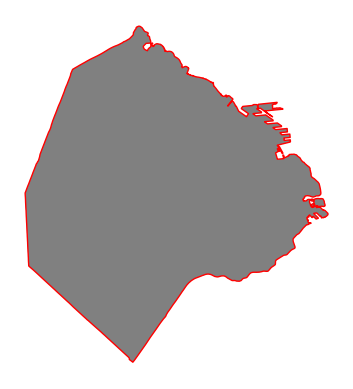

In [36]:
import osmnx as ox

gdf_caba = ox.geocode_to_gdf('Ciudad Autónoma de Buenos Aires, Argentina')
ax = gdf_caba.plot(fc='gray', ec='red')
ax.axis('off')


(np.float64(-58.541265804999995),
 np.float64(-58.325326895),
 np.float64(-34.7147786),
 np.float64(-34.517590399999996))

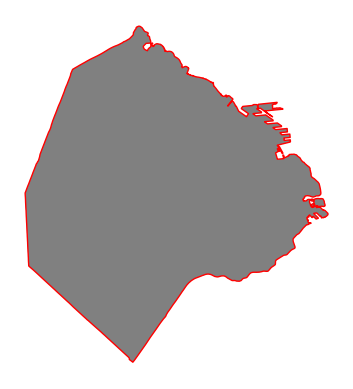